Mount Drive into Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


Install MONAI

In [ ]:
# Install monai
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 93.4 MB/s eta 0:00:00


Import Libraries

In [ ]:
# Import libraries
import os
import shutil
import tempfile
import json
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, TverskyLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Activations,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensity,
    ScaleIntensityd,
    Spacingd,
    SpatialPad,
    SpatialPadd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    ResizeWithPadOrCropd,
    RandAffined,
    ToTensord,
    Resize,
    Resized,
    EnsureTyped,
    AsDiscreted,
    RandGaussianSharpend,
    RandFlipd,
    RandRotated,
    RandZoomd,
    Rand3DElasticd,
    RandSpatialCropd,
    CenterSpatialCropd,
    Lambdad

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

Create .json File

In [ ]:
import os
import json
import random
from glob import glob

# Set random seed for reproducibility
random.seed(42)

# Define paths
image_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/"
label_dir = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/refined-labelsTr/"

# Get sorted lists of images and labels
image_files = sorted(glob(os.path.join(image_dir, "*.nii.gz")))
label_files = sorted(glob(os.path.join(label_dir, "*.nii.gz")))

print(len(image_files))
print(len(label_files))

# Ensure correct pairing
assert len(image_files) == len(label_files), "Mismatch between image and label counts."

# Extract just the filenames (without full paths)
image_names = [os.path.basename(img) for img in image_files]

# Pair images and labels
data_pairs = [{"image": f"mibirth_training/imagesTr/{img}", "label": f"mibirth_training/refined-labelsTr/{img}"} for img in image_names]

# Shuffle dataset
random.shuffle(data_pairs)

# Split dataset: 80% train, 20% validation
num_total = len(data_pairs)
num_train = int(0.8 * num_total)
num_val = num_total - num_train  # Remaining as validation

train_data = data_pairs[:num_train]
val_data = data_pairs[num_train:]

# Create JSON structure
dataset_json = {
    "description": "3D MRI Fetal Segmentation Dataset",
    "modality": {"0": "MRI"},
    "name": "fetal_mri_dataset",
    "numTraining": len(train_data),
    "numValidation": len(val_data),
    "reference": "KCL",
    "release": "1.0",
    "tensorImageSize": "3D",
    "labels": {
        "0": "background",
        "1": "class_1",
        "2": "class_2",
        "3": "class_3",
        "4": "class_4",
        "5": "class_5"
    },
    "training": train_data,
    "validation": val_data
}

# Save JSON file
json_path = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/dataset.json"
with open(json_path, "w") as json_file:
    json.dump(dataset_json, json_file, indent=4)

print(f"✅ Dataset JSON saved to {json_path}")

181
181
✅ Dataset JSON saved to /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/dataset.json


Split dataset into training and validation sets

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
data_dir = '/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/'
split_JSON = "dataset.json"
datasets = os.path.join(data_dir, split_JSON)

# Load dataset
train_files = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

Since MONAI requires uniform image sizes, let's check the min/max dimensions of the dataset:

In [ ]:
import nibabel as nib
import numpy as np
from glob import glob

# Define folder paths as strings
image_folder = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/"
label_folder = "/content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/refined-labelsTr/"

# Load all images
image_files = sorted(glob(image_folder + "*.nii.gz"))

# Get image shapes
shapes = [nib.load(f).shape for f in image_files]

# Find min/max shape
min_shape = np.min(shapes, axis=0)
max_shape = np.max(shapes, axis=0)

print(f"Minimum Image Shape: {min_shape}") # [436 544 94]
print(f"Maximum Image Shape: {max_shape}") # [436 544 135]

# images are different sizes so had to resize everything to make sure it runs smoothly

Minimum Image Shape: [436 544  50]
Maximum Image Shape: [436 544 135]


# Pre-processing

Resize Images to (128, 128, 128)

Normalize all images to a smaller size (recommended for deep learning training):

In [ ]:
# find the target shape (normalize to deep learning suitable size)
image_files = sorted(glob(image_folder + "*.nii.gz"))
shapes = [nib.load(f).shape for f in image_files]
target_size = [128, 128, 128]

In [ ]:
def combine_fetus_labels(label):
    label = label.clone()  # Avoid changing in-place
    label[label == 5] = 1  # Set all '5' to '1'
    return label

In [ ]:
# rotation degree (Rad): minimum and maximum rotation in radians for data augmentation
degree_min = -2.05
degree_max = 2.05

# define training data transformations
train_transforms = Compose([
    # load NIfTI images and labels from file paths into dictionaries with "image" and "label" keys
    LoadImaged(keys=["image", "label"]),
    # ensures the input image and label have the channel as the first dimension: [C, H, W, D]
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys="label", func=combine_fetus_labels), # combine fetus head and body
    # resample both image and label to a common voxel spacing: 0.8 mm x 0.8 mm x 4.0 mm
    Spacingd(keys=["image", "label"], pixdim=(0.8, 0.8, 4.0), mode=("bilinear", "nearest")),
    # symmetrically pad images and labels to reach the `target_size` before resizing
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, method="symmetric"),
    # resize both image and label to the target 3D shape
    Resized(keys=["image", "label"], spatial_size=target_size, mode=("trilinear", "nearest")),
    # normalize the intensity values of the image to [0, 1] or similar range
    ScaleIntensityd(keys=["image"]),
    # data augmentatin: apply random affine transformations (rotation, scale, etc.) with 70% probability
    RandAffined( # Best Avg. Dice: 0.8801067664816573
        keys=["image", "label"],
        rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)], # rotation around all 3 axes
        mode=("bilinear", "nearest"),
        padding_mode=("zeros"), # pad with zeros outside original bounds
        prob=0.70,
    ),
    ToTensord(keys=["image", "label"]), # convert image and label to PyTorch tensors
])

# define validation data transformations (no augmentation)
val_transforms = Compose([
    # load NIfTI images and labels from file paths into dictionaries with "image" and "label" keys
    LoadImaged(keys=["image", "label"]),
    # ensures the input image and label have the channel as the first dimension: [C, H, W, D]
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys="label", func=combine_fetus_labels),
    # Resample both image and label to a common voxel spacing: 0.8 mm x 0.8 mm x 4.0 mm
    Spacingd(keys=["image", "label"], pixdim=(0.8, 0.8, 4.0), mode=("bilinear", "nearest")),
    # symmetrically pad images and labels to reach the `target_size` before resizing
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, method="symmetric"),
    # resize both image and label to the target 3D shape
    Resized(keys=["image", "label"], spatial_size=target_size, mode=("trilinear", "nearest")),
    # normalize the intensity values of the image to [0, 1] or similar range
    ScaleIntensityd(keys=["image"]),
    ToTensord(keys=["image", "label"]), # convert image and label to PyTorch tensors
])

If output is [0, 1] → Binary segmentation (foreground vs background)
- Set: lab_num = 1, class_num = 2

If output is [0, 1, 2, 3] → Multi-class segmentation
- Set: lab_num = 3, class_num = 4

Segmentation masks contain the values:
[0, 1, 2, 3, 4, 5]

This means:
- 0 → Background
- 1, 2, 3, 4, 5 → 5 foreground classes

Setting up the data pipeline for training a fetal MRI segmentation model using MONAI.

*   Transforms: loads and formats the images, resamples to a standard voxel size, pad and resize them to a fixed shape, normalize intensity, and applies random 3D rotations during training for data augmentation.
*   Labels: simplifies segmentation task by combining related fetal structures (like head and body) into one label.
*   Datasets: CacheDataset speeds things up by keeping preprocessed data in memory.
  * data: list of dictionaries with "image" and "label" paths
  * transform: preprocessing and augmentation pipeline
  * cache_num: number of items to cache in memory (speeds up training)
  * cache_rate: 1.0 means cache all items (useful if memory allows)
  * num_workers: number of parallel threads to load data
*   DataLoaders: handles batching and loading the data — with shuffling for training and fixed order for validation.
  * batch_size = 1 (you can increase if you have enough GPU memory)
  * shuffle = True to randomize the batches
  * pin_memory = True improves GPU data transfer speed

This ensures consistent, fast, and augmented data flow to the model.

In [ ]:
# Create datasets and dataloaders
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_num=100, cache_rate=1.0, num_workers=8)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


In [ ]:
# Check transformed shapes
def check_transformed_shapes(dataloader, dataset_name):
    print(f"Checking {dataset_name} dataset shapes after transformation:")
    for i, batch in enumerate(dataloader):
        image, label = batch["image"], batch["label"]
        print(f"Sample {i}: Image shape {image.shape}, Label shape {label.shape}")
        if i == 4:
            break  # Check first 5 samples

check_transformed_shapes(train_loader, "Training")
check_transformed_shapes(val_loader, "Validation")

Checking Training dataset shapes after transformation:
Sample 0: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 1: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 2: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 3: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 4: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Checking Validation dataset shapes after transformation:
Sample 0: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 1: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 2: Image shape torch.Size([1, 1, 128, 128, 128]), Label shape torch.Size([1, 1, 128, 128, 128])
Sample 3: Image shape torch.Size([1, 1, 128, 128, 128]), Label s

Visualise validation sets

0 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/019101.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


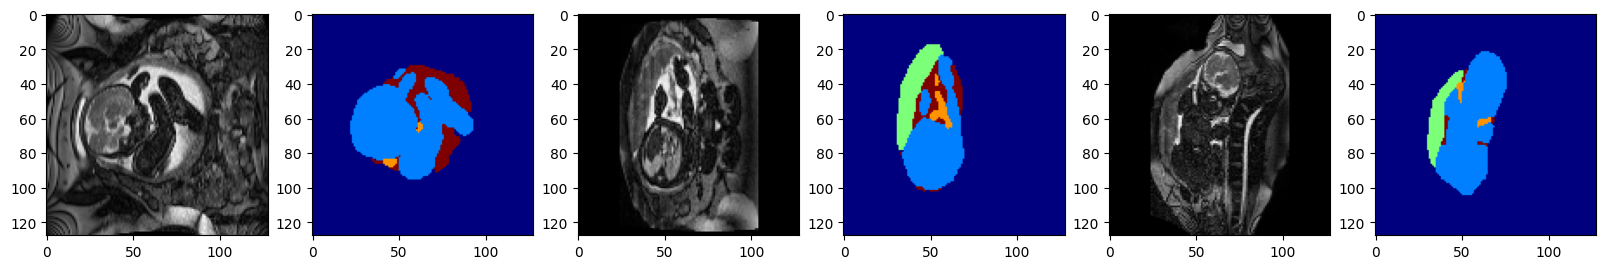

1 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/009001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


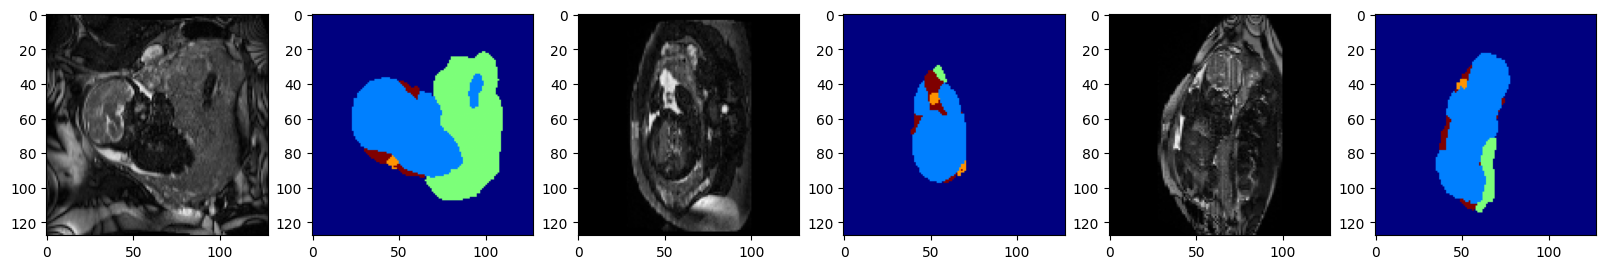

2 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/017401.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


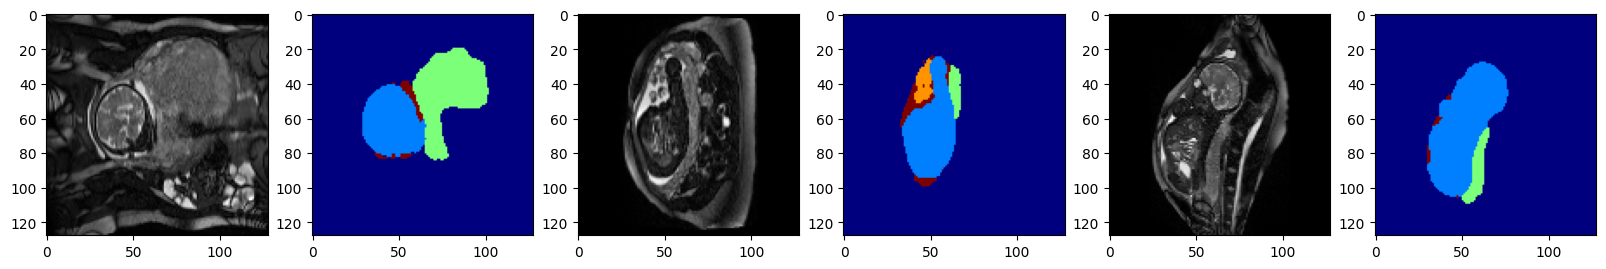

3 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/004002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


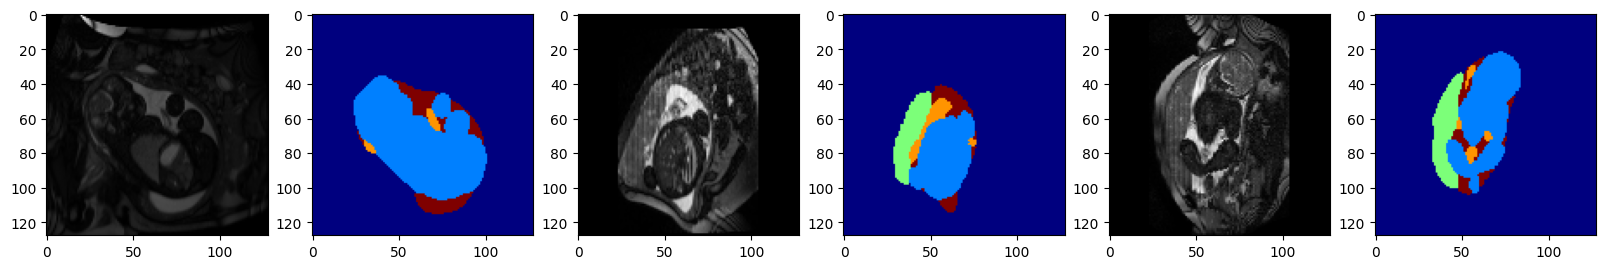

4 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/016301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


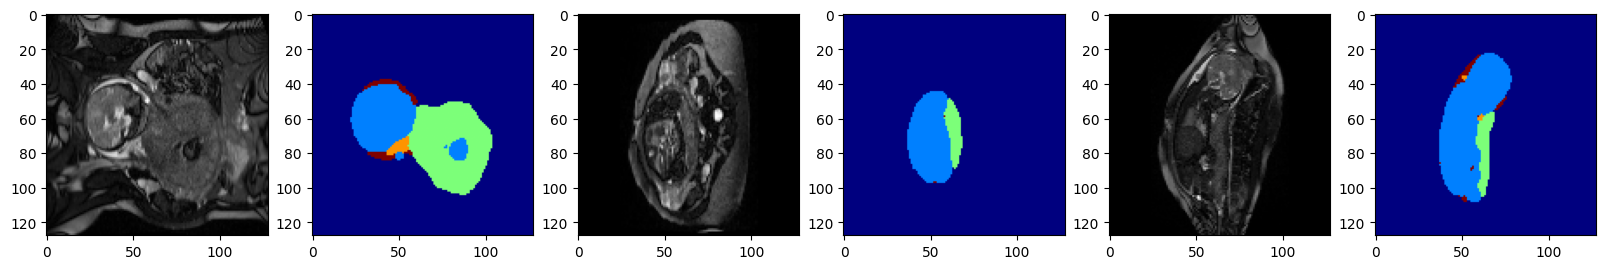

5 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/009101.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


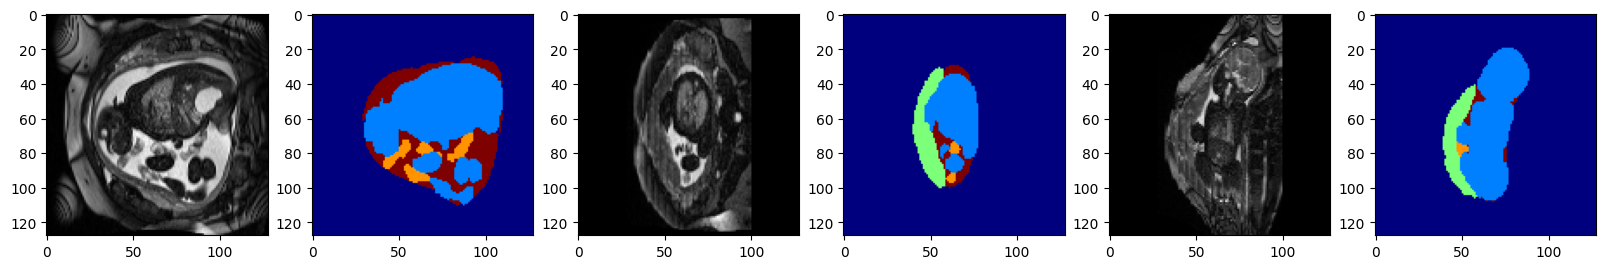

6 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/017801.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


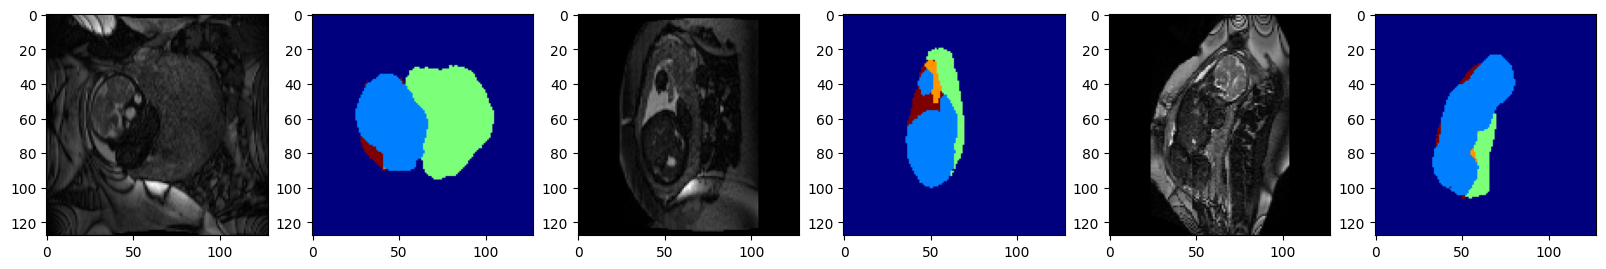

7 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/004101.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


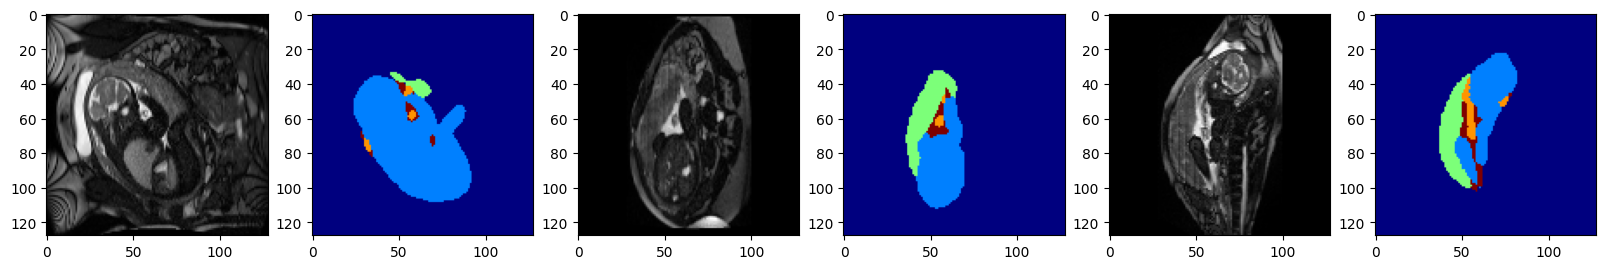

8 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/000201.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


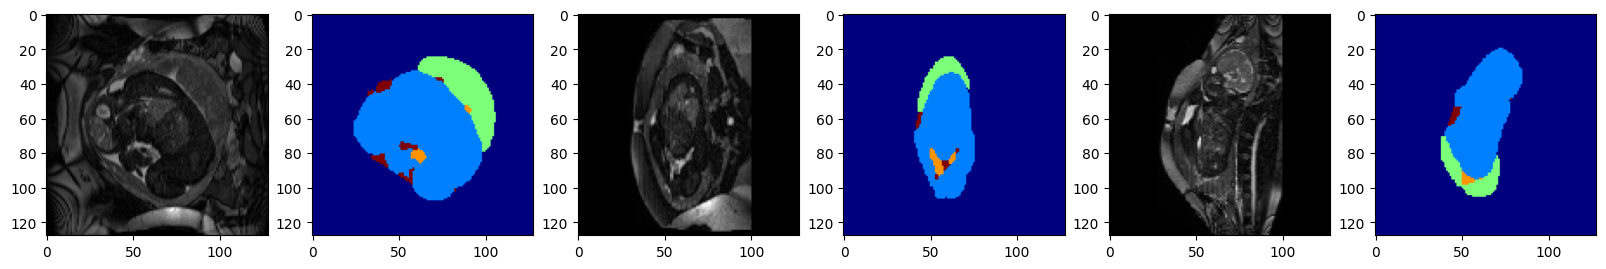

9 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/007301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


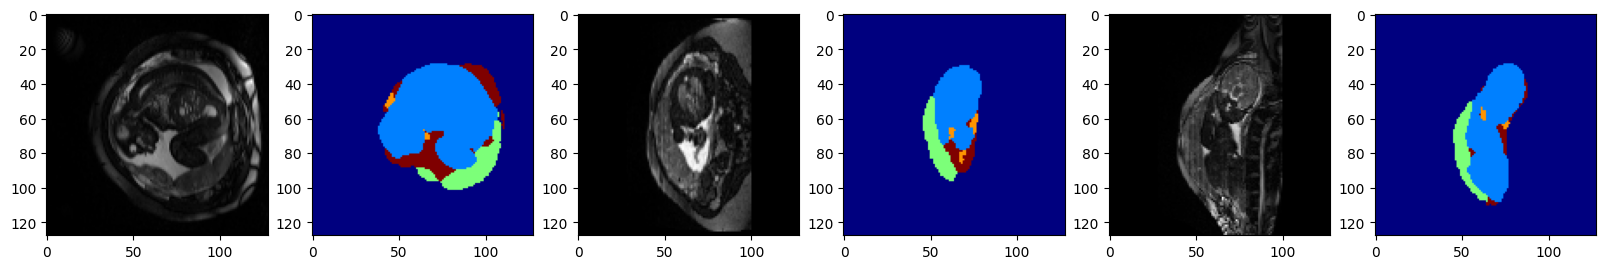

10 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/016001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


11 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/012001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


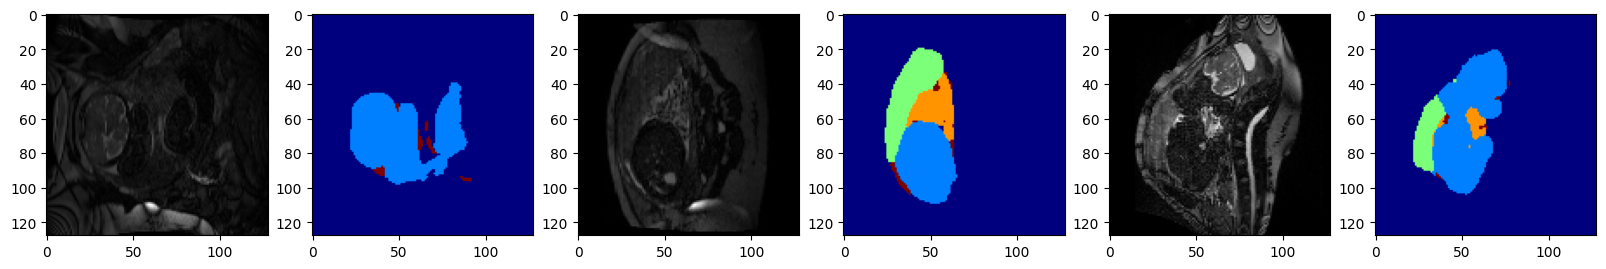

12 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/005801.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


13 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/011201.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


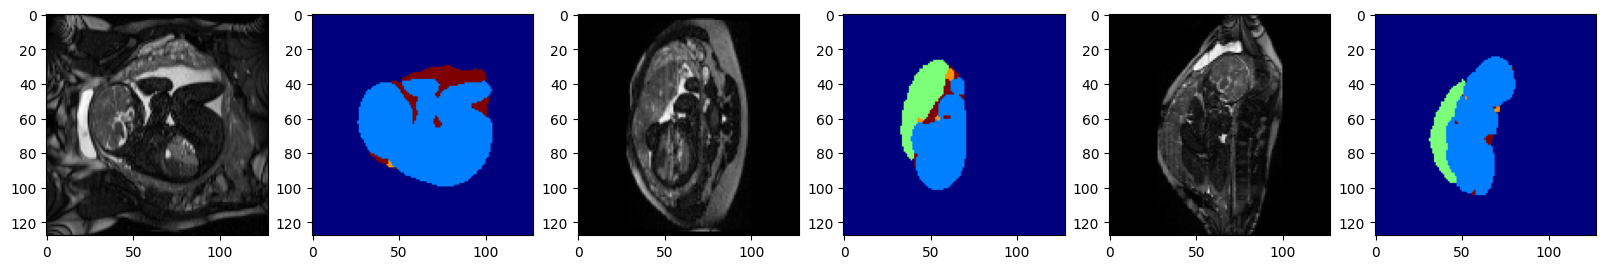

14 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/019001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


15 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/005301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


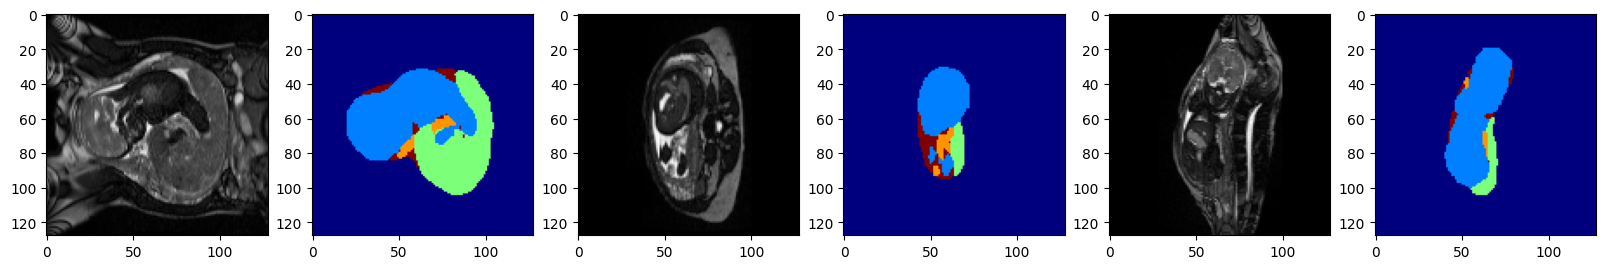

16 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/015301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


17 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/019601.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


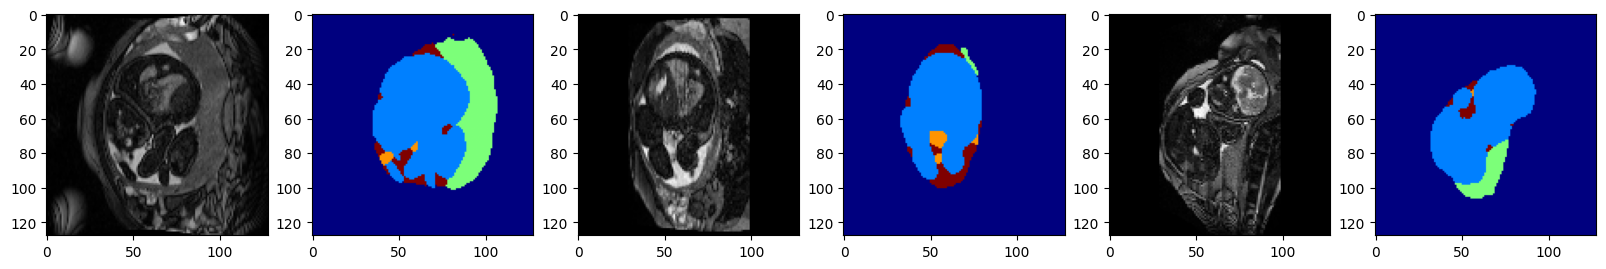

18 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/016401.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


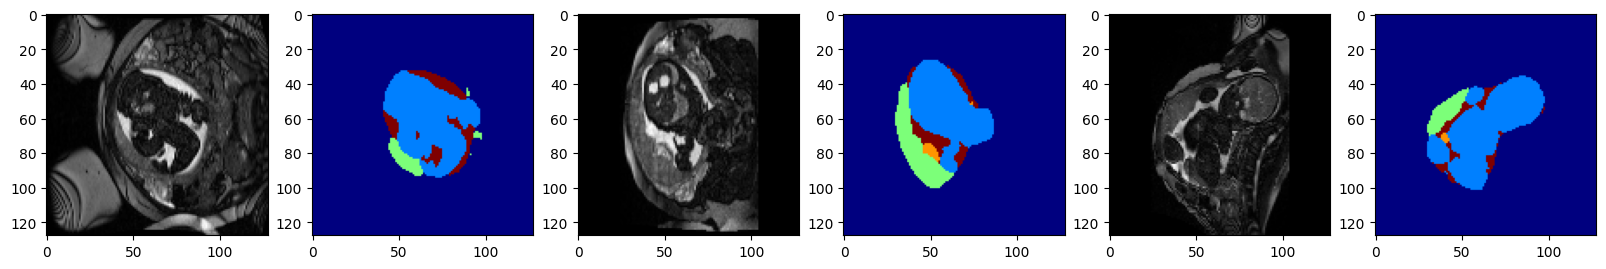

19 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/013701.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


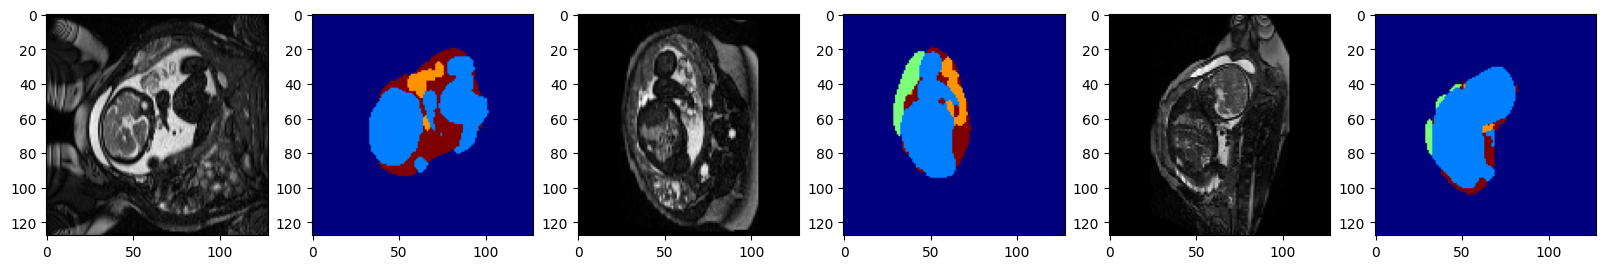

20 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/006101.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


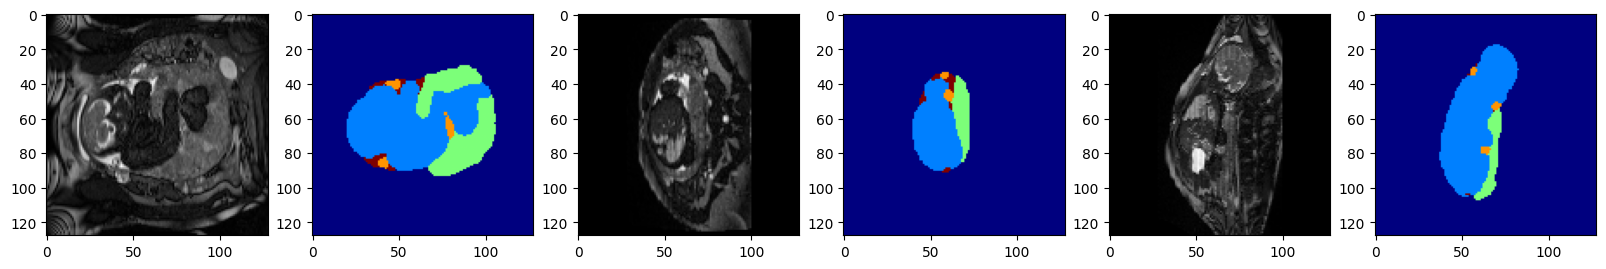

21 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/005701.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


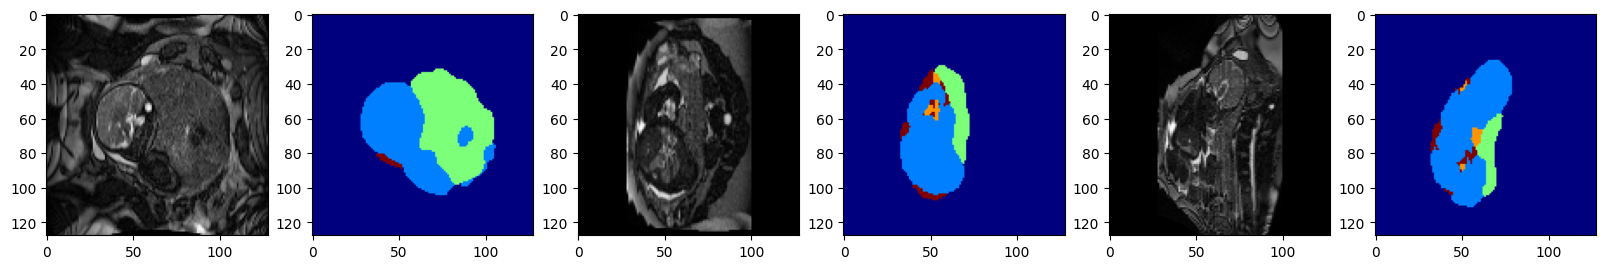

22 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/002302.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


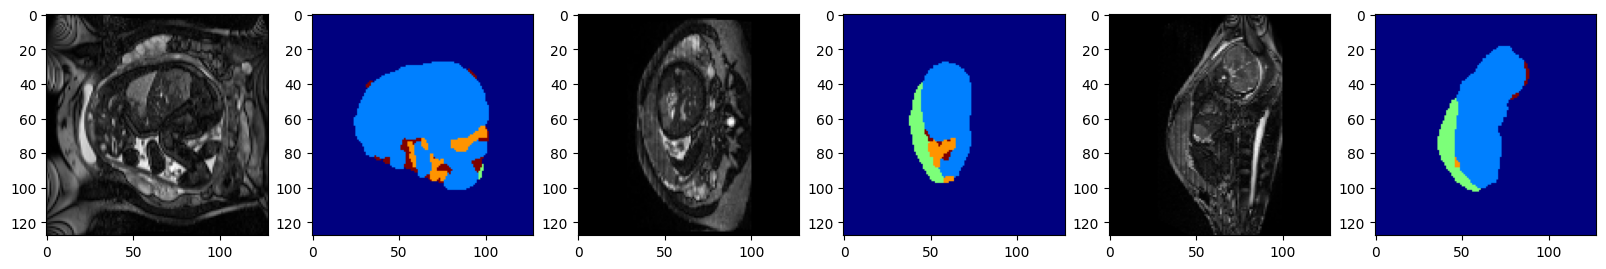

23 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/000801.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


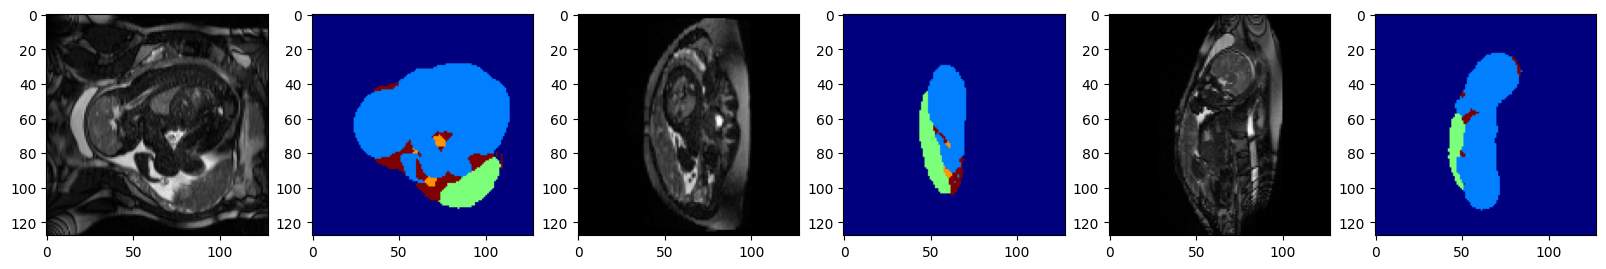

24 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/000901.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


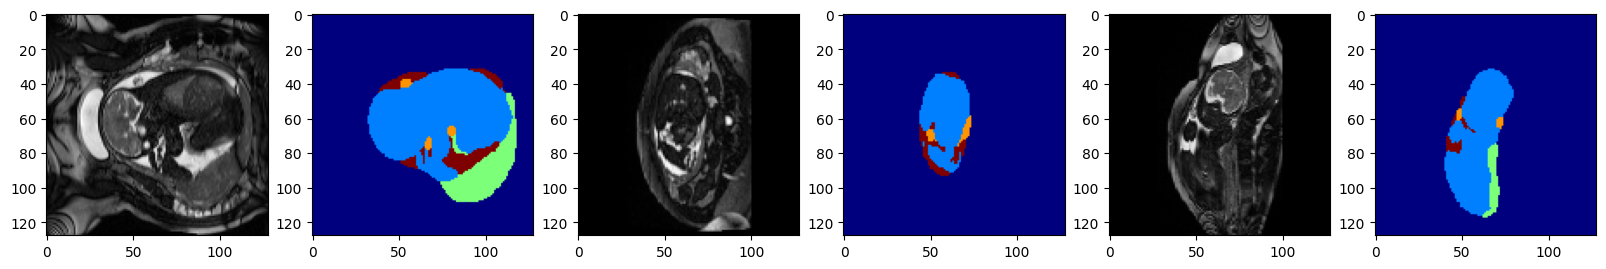

25 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/011301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


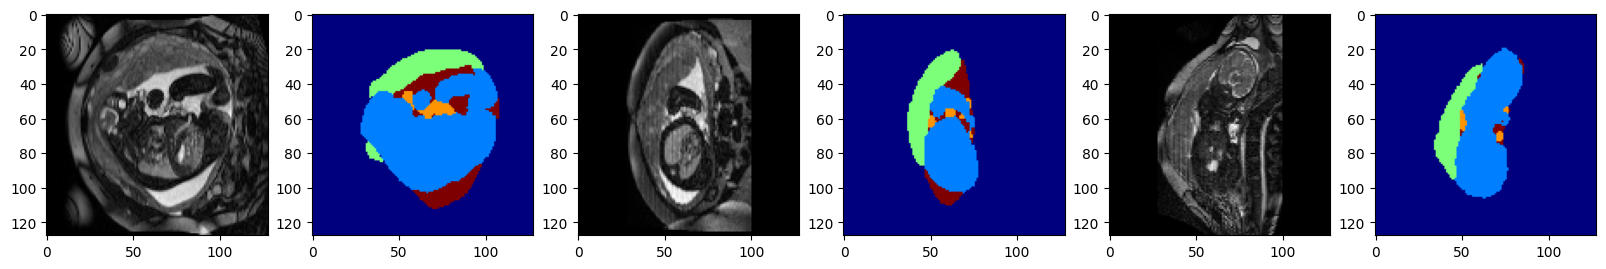

26 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/016101.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


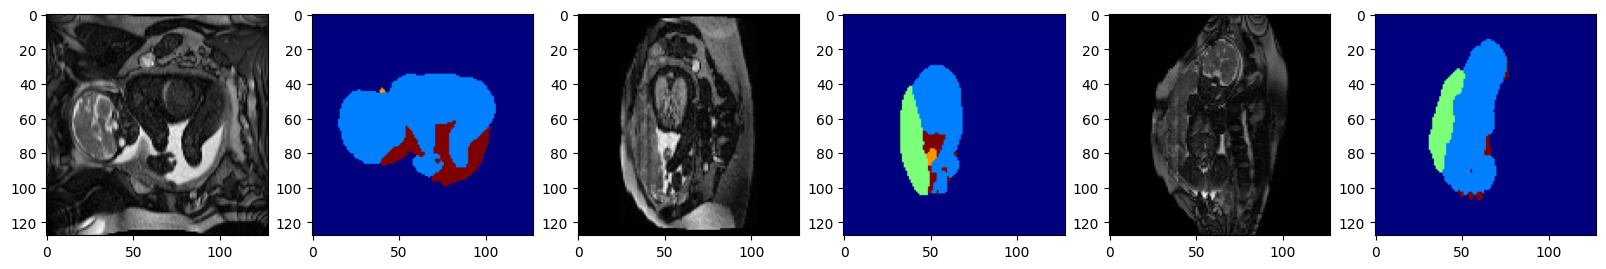

27 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/002301.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


28 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/014801.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


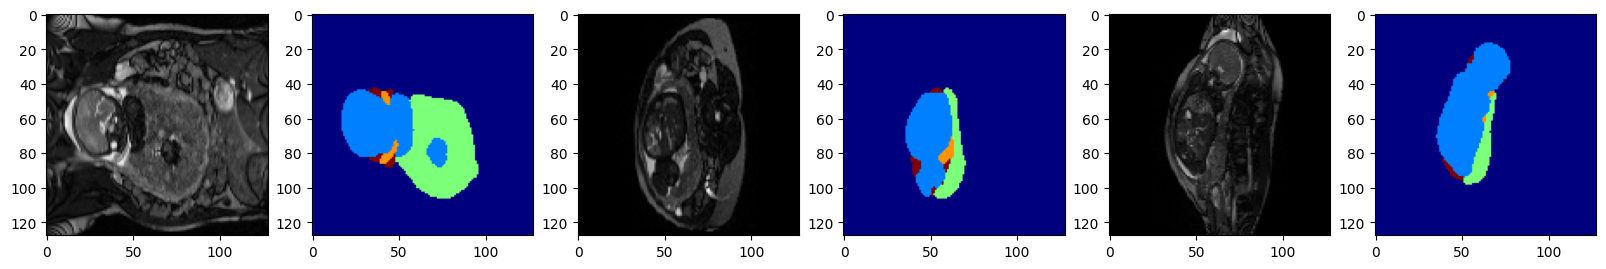

29 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/002901.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


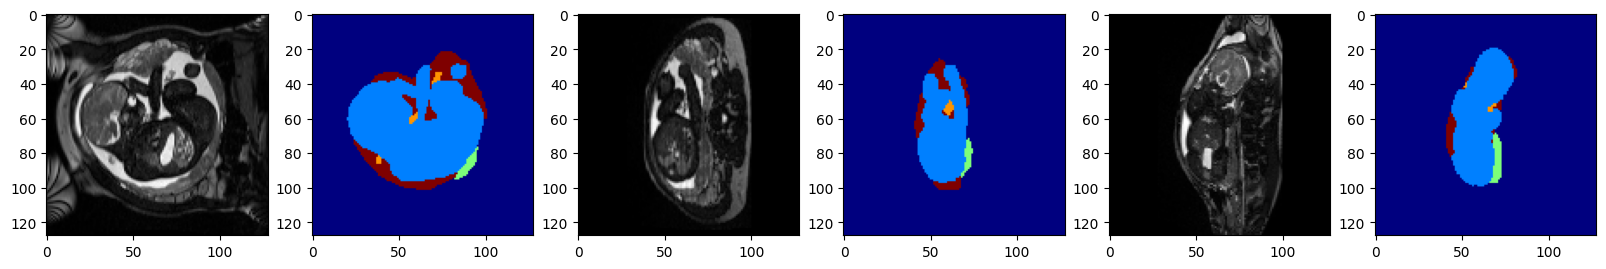

30 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/003701.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


31 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/005901.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


32 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/006401.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


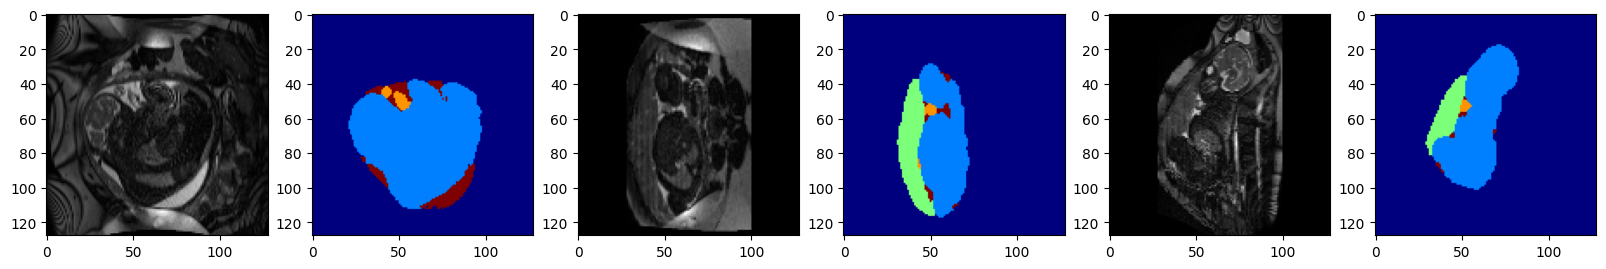

33 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/007201.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


34 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/000701.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


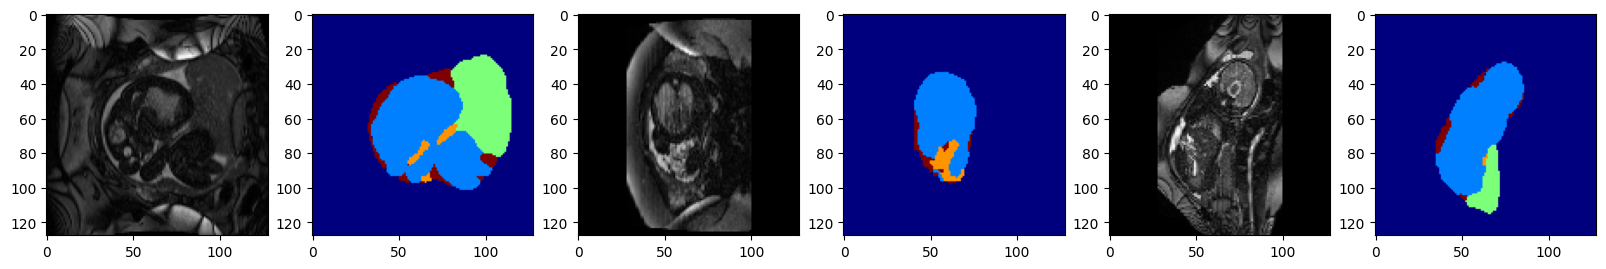

35 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/003002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


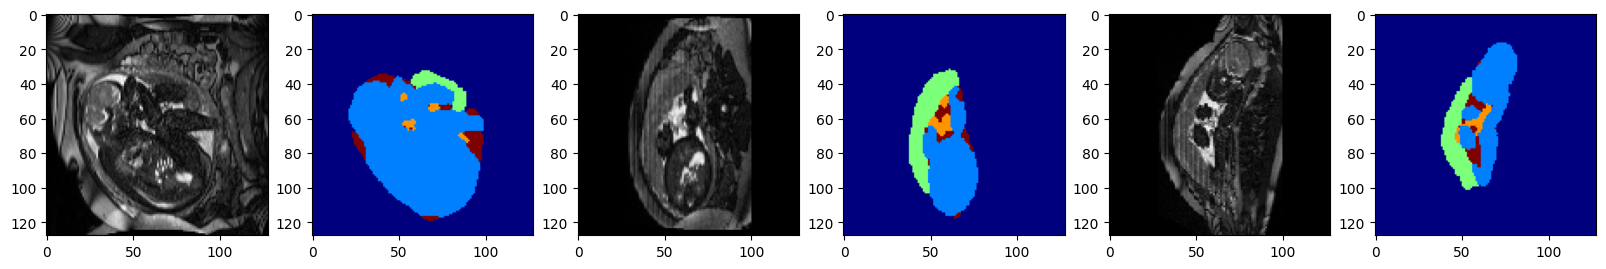

36 /content/drive/My Drive/BEng/Year3/Research_Project/MONAI_training/mibirth-segmentation/mibirth_training/imagesTr/017202.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


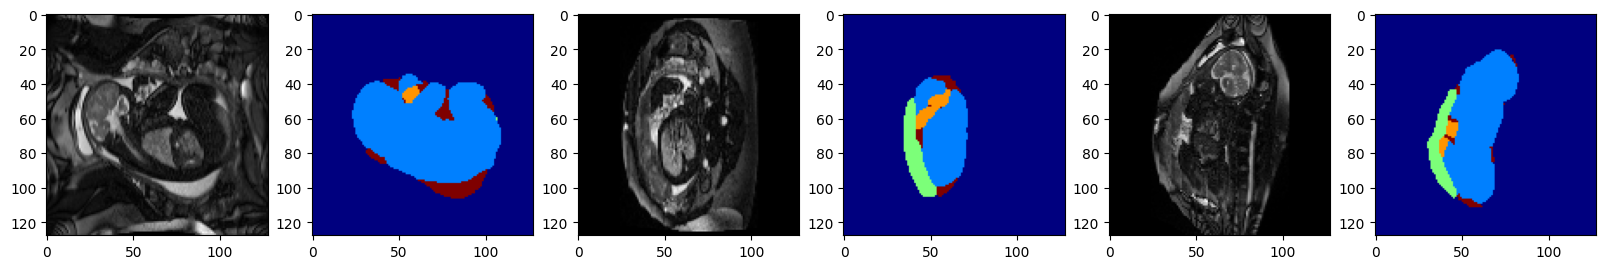

In [ ]:
s=round(128/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["image"]
  label_name = val_files[case_num]["label"]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, img_name, img_shape, label_shape)
  plt.figure("image", (20, 50))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()